<a href="https://colab.research.google.com/github/sandeepbansode/Machine_Learning_Data_Science/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement: Twitter Sentiment Analysis**
Sentiment Analysis refers to the use of natural language processing,text analysis,computational linguistics, and biometricsto systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.


## **Motivation**
Hate  speech  is  an  unfortunately  common  occurrence  on  the  Internet.  Often social media sites like Facebook and Twitter face the problem of identifying and censoring  problematic  posts  while weighing the right to freedom of speech. The  importance  of  detecting  and  moderating hate  speech  is  evident  from  the  strong  connection between hate speech and actual hate crimes. Early identification of users promoting  hate  speech  could  enable  outreach  programs that attempt to prevent an escalation from speech to action. Sites such as Twitter and Facebook have been seeking  to  actively  combat  hate  speech. In spite of these reasons, NLP research on hate speech has been very limited, primarily due to the lack of a general definition of hate speech, an analysis of its demographic influences, and an investigation of the most effective features.

In [3]:

import re # for regular expressions
import nltk # for text manipulation
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
import nltk
from nltk.corpus import stopwords

### **Load data**

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Data Science Files/Twitter Sentiment Analysis/train_E6oV3lV.csv')
test  = pd.read_csv('/content/drive/MyDrive/Data Science Files/Twitter Sentiment Analysis/test_tweets_anuFYb8.csv')

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
#Let's check out a few non racist?sexist tweets
train[train['label']==0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [7]:
 #Let's check out a few racist?sexist tweets
train[train['label']==1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


There are quite a many words and characters which are not really required. so, we will try to keep only those words which are important and add value.

Lets Check dimensions of train and test dataset

In [8]:
train.shape,test.shape

((31962, 3), (17197, 2))

Train set has 31,962 tweets and test set has 17,197 tweets.

Lets have glimpse at label-distribution in the train dataset

In [9]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In train dataset we have 2242 tweets labeled as racist or sexist, and 29720 tweets labeled as non racist/sexist. So,it is an imbalanced classification challenge.

---
Now we will check the distribution of length of the tweets, in terms of words,in both train and test data.

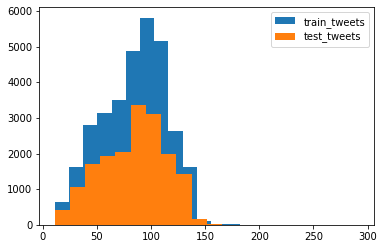

In [10]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.hist(length_train, bins = 20 , label = "train_tweets")
plt.hist(length_test, bins = 20 , label = "test_tweets")
plt.legend()
plt.show()

---

## **Data Cleaning**

In any natural language processing task, cleaning raw text data is an important step. it helps in getting rid of the unwanted words and characters which helps in obtaining better features. if we skip this step then there is higher chance you are working with noisy and inconsistent data. The objective of this step is to clean noise those  are less relevant to find the sentiment of tweets such as puncuation, special characters,numbers,and terms which dont carry much weightage in context to the text.

Before we begin cleaning, lets first combine train and test dataset. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [11]:
#combine train and test dataset
combi = train.append(test,ignore_index=True)
combi.shape

(49159, 3)

In [12]:
#remove unwanted text patterns from the tweets
def remove_pattern(input_txt,pattern):
  r = re.findall(pattern,input_txt)
  for i in r:
    input_txt = re.sub(i,'',input_txt)
  return input_txt  

## **we will be following the steps below to clean the raw tweets in to our data.**


1.   We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any infomation about the nature of the tweet.
2.   We will also get rid of punctuations,numbers and even spcial characters since they wouldn't help differentiating types of tweets.
3.  Most of the similar words do not much value. For example, 'pdx','his','all'.So we will try to remove them as well from our data.
4.   Lastly, we will normalize the text data. For example, reducing terms like loves,loving and lovable to their base word i.e., 'love'. are often used in the same context. if we can reduce them to their root words, which is 'love'. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

---

###1.  **Removing Twitter Handles(@user)**
Let's create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed '@[]*' as the pattern to remove_pattern function. it is actually a regular expression which will pick any words starting with '@'





In [13]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'],'@[\w]*')

combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


---

### **2.Removing Punctuations, Numbers, spacial Characters and Stop Words**

Here we will replace everything except characters and hashtags with spaces. The regular expression "[^a-zA-Z#]" means anything except alphabets and '#'.


In [14]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

nltk.download('stopwords')
combi['tidy_tweet']=combi['tidy_tweet'].apply(lambda x: tweet_to_words(x))

combi.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday your majesty,bihday majesty
3,4,0.0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0.0,factsguide: society now #motivation,factsguide society motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare big talking leave chaos pay disp...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,next school year year exams think school exams...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,love land allin cavs champions cleveland cleve...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome gr


---

### **3. Removing short Words**

We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [15]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3 ]))

In [16]:
#Let’s take another look at the first few rows of the combined dataframe.

combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cause offer wheelchair vans...
2,3,0.0,bihday your majesty,bihday majesty
3,4,0.0,#model i love u take with u all the time in ...,model love take time
4,5,0.0,factsguide: society now #motivation,factsguide society motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fare talking leave chaos disputes allshow...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,next school year year exams think school exams...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,love land allin cavs champions cleveland cleve...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

---

### **4. Spelling Correction**
Our data extracted from customer tweets have some chances of spelling mistakes.

Correcting spelling mistakes improves model accuracy.

There are various libraries to fix spelling mistakes, but the most convenient method is to use a text blob.

The method correct() works on text blob objects and corrects the spelling mistakes.

In [17]:
#Install textblob library 
!pip install textblob 
from textblob import TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
%%time
#combi['tidy_tweet'].apply(lambda x: str(TextBlob(x).correct()))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


---

### **5. Text Normalization**

Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [19]:
%%time
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) #tokenizing
tokenized_tweet.head()

CPU times: user 178 ms, sys: 26.8 ms, total: 205 ms
Wall time: 206 ms


0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, lyft, credit, cause, offer, wheelchai...
2                                    [bihday, majesty]
3                            [model, love, take, time]
4                    [factsguide, society, motivation]
Name: tidy_tweet, dtype: object

Now we can normalize the tokenized tweets.

In [20]:
%%time
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #stemming

CPU times: user 12.5 s, sys: 107 ms, total: 12.6 s
Wall time: 16.5 s


Now let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

In [21]:
%%time
for i in range (len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet  

CPU times: user 791 ms, sys: 3.72 ms, total: 795 ms
Wall time: 1.22 s


---

# **Visualization from Tweets**

we will explore the cleaned tweets. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. Do not limit yourself to only these methods told in this course, feel free to explore the data as much as possible.

---

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

* What are the most common words in the entire dataset?
* What are the most common words in the dataset for negative and positive tweets, respectively?
* How many hashtags are there in a tweet?
* Which trends are associated with my dataset?
* Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

---
### **A) Understanding the common words used in the tweets: WordCloud**

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

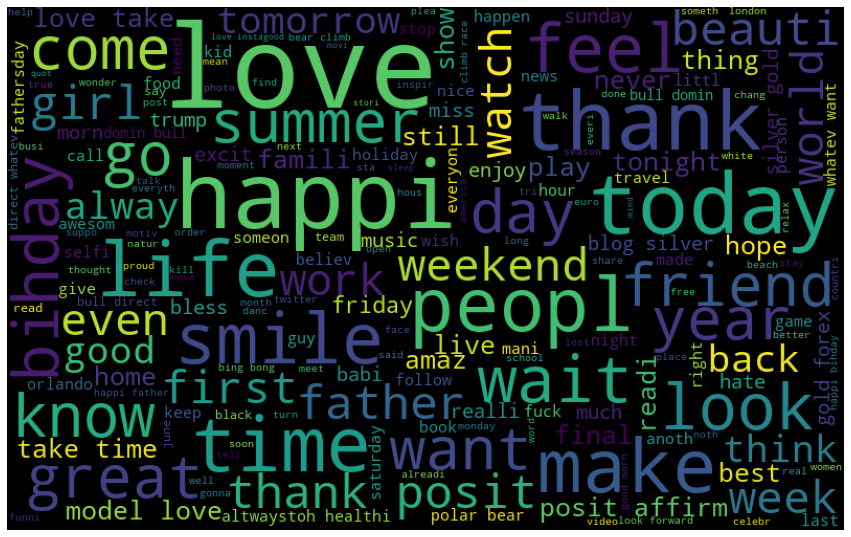

In [22]:
all_words = ' '.join([text for text in combi['tidy_tweet']]) 
from wordcloud import WordCloud
WordCloud = WordCloud(width = 800 , height = 500 , random_state = 42 , max_font_size = 110 ).generate(all_words)
plt.figure(figsize=(15,10))
plt.imshow(WordCloud)
plt.axis('off')
plt.show()


We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

---
### **B) Words in non racist/sexist tweets**

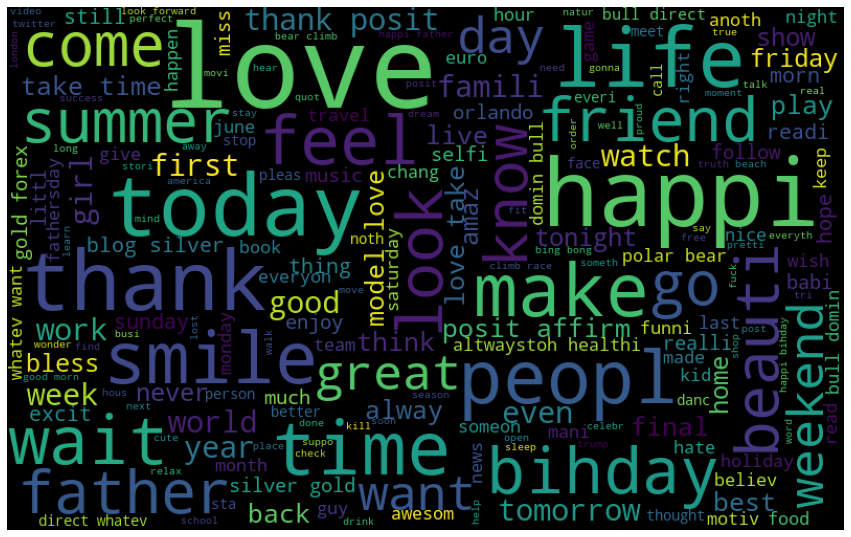

In [23]:
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label']==0]])
from wordcloud import WordCloud
WordCloud = WordCloud(width = 800 , height = 500 , random_state = 42 , max_font_size = 110 ).generate(normal_words)
plt.figure(figsize=(15,10))
plt.imshow(WordCloud)
plt.axis('off')
plt.show()


Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

---

### **C) Racist/Sexist Tweets**

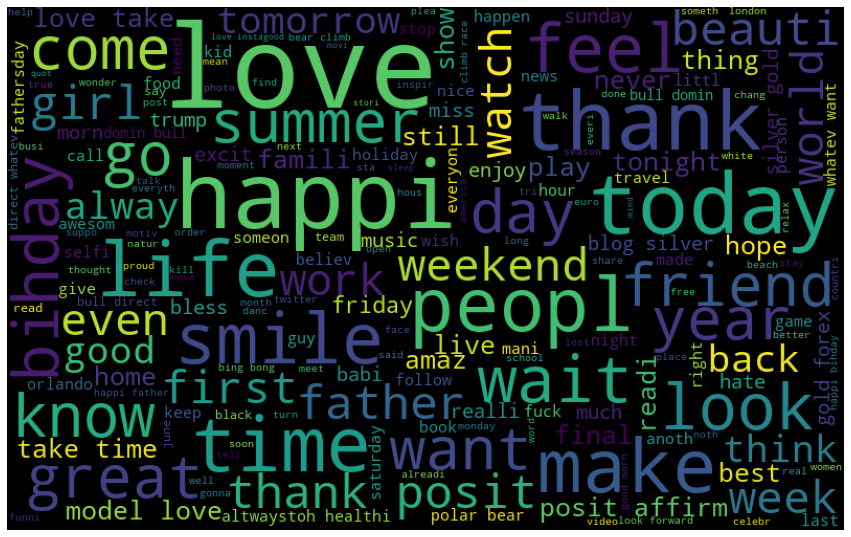

In [24]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label']==1]])
from wordcloud import WordCloud
WordCloud = WordCloud(width = 800 , height = 500 , random_state = 42 , max_font_size = 110 ).generate(all_words)
plt.figure(figsize=(15,10))
plt.imshow(WordCloud)
plt.axis('off')
plt.show()



As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

---

### **D) Understanding the impact of Hashtags on tweets sentiment**
Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:

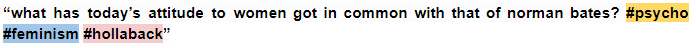

The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [25]:
# function to collect hashtags 
def hashtag_extract(x):
  hashtags = []    
# Loop over the words in the tweet    
  for i in x:
    ht = re.findall(r"#(\w+)", i)        
    hashtags.append(ht)
  return hashtags
# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(combi['tweet'][combi['label'] == 0]) 
# extracting hashtags from racist/sexist tweets 
HT_negative = hashtag_extract(combi['tweet'][combi['label'] == 1]) 
# unnesting list 
HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top ‘n’ hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

---

### **Non-Racist/Sexist Tweets**

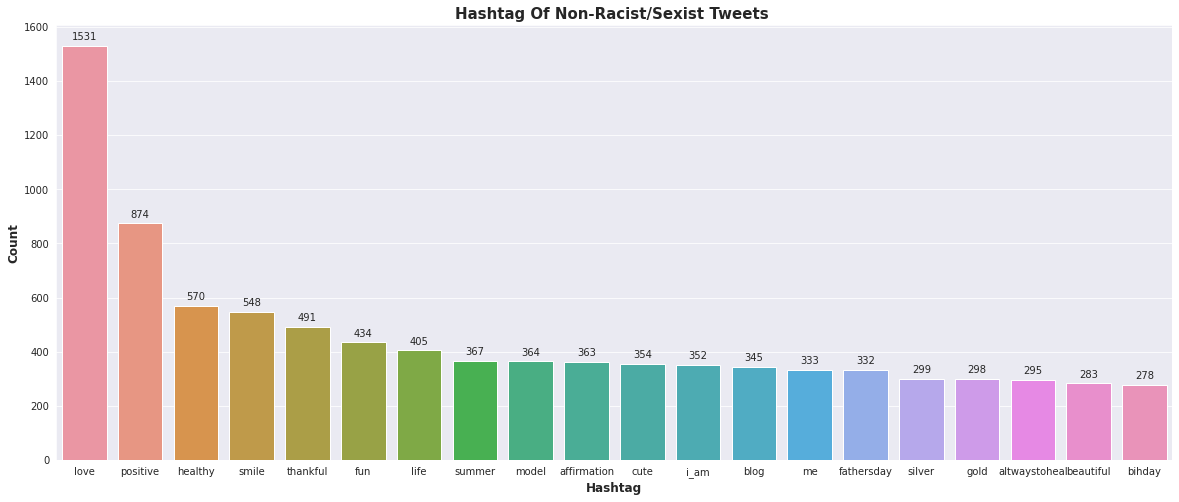

In [26]:
a = nltk.FreqDist(HT_regular) 
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x='Hashtag', y='Count', data = d,alpha=1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Hashtag Of Non-Racist/Sexist Tweets ',weight='bold', size=15)
plt.ylabel('Count', size=12, weight='bold')
plt.xlabel('Hashtag', size=12, weight='bold')
plt.show() 

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

---


### **Racist/Sexist Tweets**

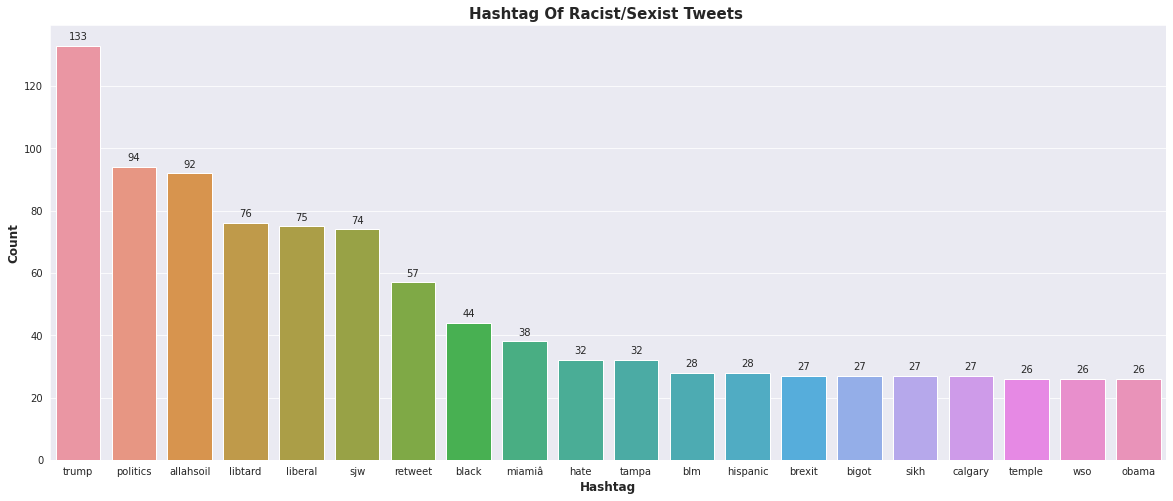

In [27]:
b = nltk.FreqDist(HT_negative) 
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 20 most frequent hashtags 
e = e.nlargest(columns="Count", n = 20)  

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x='Hashtag', y='Count', data = e,alpha=1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Hashtag Of Racist/Sexist Tweets ',weight='bold', size=15)
plt.ylabel('Count', size=12, weight='bold')
plt.xlabel('Hashtag', size=12, weight='bold')
plt.show() 

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

-----

## **Bag-of-Words Features**

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings. 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
import gensim

In [29]:
bow_vectorizer = CountVectorizer(max_df = 0.90 , min_df = 2 , max_features= 1000 , stop_words = 'english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

---

## **TF-IDF Features**

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

* TF = (Number of times term t appears in a document)/(Number of terms in the document)

* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

* TF-IDF = TF*IDF






In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90 , min_df = 2, max_features=1000, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

---

## **Word2Vec Features**



Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are able to achieve tasks like **King -man +woman = Queen**, which is mind-blowing.

The advantages of using word embeddings over BOW or TF-IDF are:

1. Dimensionality reduction - significant reduction in the no. of features required to build a model.

2. It capture meanings of the words, semantic relationships and the different types of contexts they are used in.



##**1. Word2Vec Embeddings**

Word2Vec is not a single algorithm but a combination of two techniques – CBOW (Continuous bag of words) and Skip-gram model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.



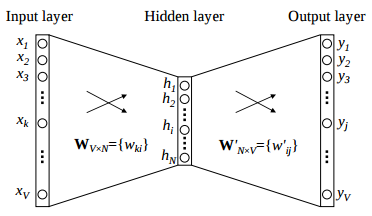

There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

1. It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

2. Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using pre-trained word vectors instead of training our own model. Some of the freely available pre-trained vectors are:

1. Google News Word Vectors

2. Freebase names

3. DBPedia vectors (wiki2vec)

However, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec model on our corpus.

In [31]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(5642492, 6458140)

Let’s play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [32]:
model_w2v.wv.most_similar(positive="dinner")

[('bolognes', 0.5665344595909119),
 ('whoopppp', 0.5543392896652222),
 ('foodcoma', 0.546721875667572),
 ('seafood', 0.5436416268348694),
 ('bihdaydinn', 0.5413813591003418),
 ('foodblogg', 0.5339366793632507),
 ('cellar', 0.5330343246459961),
 ('spaghetti', 0.5330177545547485),
 ('mojito', 0.5315989255905151),
 ('photoftheday', 0.5297595262527466)]

In [33]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.5917341113090515),
 ('dumptrump', 0.580974817276001),
 ('neverump', 0.5698695778846741),
 ('melo', 0.5413093566894531),
 ('donthecon', 0.5380213260650635),
 ('potu', 0.530556321144104),
 ('phoni', 0.530547022819519),
 ('versa', 0.5297682881355286),
 ('trumpleak', 0.5272547006607056),
 ('unfit', 0.5266790390014648)]

From the above two examples, we can see that our word2vec model does a good job of finding the most similar words for a given word. But how is it able to do so? That’s because it has learned vectors for every unique word in our data and it uses cosine similarity to find out the most similar vectors (words).

Let’s check the vector representation of any word from our corpus.

In [34]:
model_w2v['food']

array([-0.01299965,  0.11818041, -0.49128807,  0.34540895, -0.4517599 ,
       -0.4656155 , -0.26093656,  0.3451051 , -0.45468304,  0.1786355 ,
       -0.08961267,  0.744331  ,  0.37785596,  0.9329046 ,  0.44950533,
        1.0722561 ,  0.03192918, -0.6835485 , -0.24008752,  0.42896804,
       -0.5751961 , -0.12596524, -0.20309524,  0.9280752 ,  0.25487834,
       -0.1573329 ,  0.00265636,  0.14375761,  0.14677909,  0.00162903,
       -0.30868316,  0.4753906 , -0.19557104, -0.26772603,  0.2021866 ,
       -0.60820156, -0.33967677,  0.30992955, -0.62193143,  0.08978341,
        0.1954667 ,  0.53627974, -0.06626561,  0.32787162,  0.7678354 ,
       -0.67615247,  0.47416282, -0.1702788 , -0.08068434,  0.06980487,
        0.8271476 ,  0.19260943, -0.59969634, -0.732025  , -1.1900138 ,
        0.42356285, -0.45142   ,  0.16805023, -0.14739655, -0.34635016,
       -0.3735319 ,  0.26865876,  0.20588696,  1.1103349 ,  0.6739705 ,
        0.52674764,  0.75718087, -0.08147457, -0.31183684, -0.83

In [35]:
len(model_w2v['food']) #The length of the vector is 200

200

---

### **Preparing Vectors for Tweets**

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [36]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary                                     
          continue
    if count != 0:
        vec /= count
    return vec

Preparing word2vec feature set…

In [37]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays) 

wordvec_df.shape  

(49159, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.

---

### **2. Doc2Vec Embedding**

Doc2Vec model is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. This approach is an extension of the word2vec. The major difference between the two is that doc2vec provides an additional context which is unique for every document in the corpus. This additional context is nothing but another feature vector for the whole document. This document vector is trained along with the word vectors.

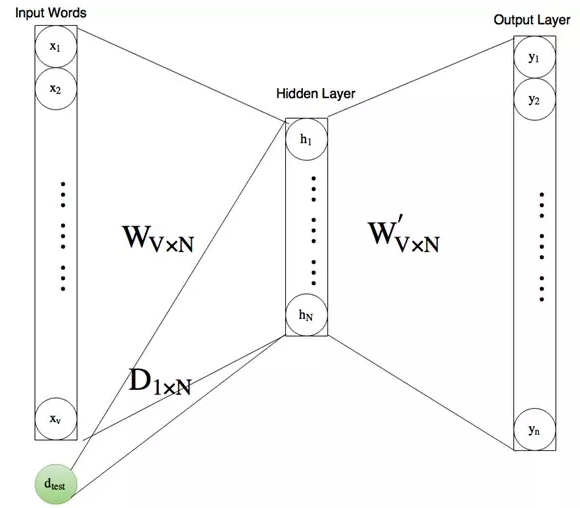

Let’s load the required libraries.

In [38]:
# Let’s load the required libraries.
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence


To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [39]:
def add_label(twt):
  output = []
  for i, s in zip (twt.index , twt):
    output.append(LabeledSentence(s,["tweet_" + str(i)]))
  return output

labeled_tweets = add_label(tokenized_tweet) #label all tweets

Let’s have a look at the result.

In [40]:
labeled_tweets[:5]

[LabeledSentence(words=['father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct'], tags=['tweet_0']),
 LabeledSentence(words=['thank', 'lyft', 'credit', 'caus', 'offer', 'wheelchair', 'van', 'disapoint', 'getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['model', 'love', 'take', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', 'motiv'], tags=['tweet_4'])]

Now let’s train a doc2vec model.

In [42]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model                                   
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors                                  
                                  size=200, # no. of desired features                                  
window=5, # width of the context window                                  
negative=7, # if > 0 then negative sampling will be used                                 
min_count=5, # Ignores all words with total frequency lower than 2.                                  
workers=3, # no. of cores                                  
alpha=0.1, # learning rate                                  
seed = 23) 
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])
model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=15)

100%|██████████| 49159/49159 [00:00<00:00, 2147185.59it/s]


### **Preparing doc2vec Feature Set**

In [43]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(combi)):
  docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

---

## **Modeling**

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
2. Support Vector Machine
3. RandomForest
4. XGBoost

### **Evaluation Metric**

**F1 score** is being used as the evaluation metric. It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

The important components of F1 score are:

1. True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
2. True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
3. False Positives (FP) – When actual class is no and predicted class is yes.
4. False Negatives (FN) – When actual class is yes but predicted class in no.

Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2(Recall Precision) / (Recall + Precision)

---

### **Logistic Regression**

Logistic Regression is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. You can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as the dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score

### Bag-of-Words Features

We will first try to fit the logistic regression model on the Bag-of_Words (BoW) features.

In [45]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 
# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],random_state=42,test_size=0.3)
lreg = LogisticRegression() 
# training the model 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) 
# predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 

f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5295587010824313

### **TF-IDF Features**

We’ll follow the same steps as above, but now for the TF-IDF feature set.

In [46]:
train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 
xtrain_tfidf = train_tfidf[ytrain.index] 
xvalid_tfidf = train_tfidf[yvalid.index]
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5367581930912312

### **Word2Vec Features**

In [47]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]
xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain)
prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.597667638483965

### **Doc2Vec Features**

In [48]:
train_d2v = docvec_df.iloc[:31962,:] 
test_d2v = docvec_df.iloc[31962:,:] 
xtrain_d2v = train_d2v.iloc[ytrain.index,:] 
xvalid_d2v = train_d2v.iloc[yvalid.index,:]
lreg.fit(xtrain_d2v, ytrain) 
prediction = lreg.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.3495652173913043

Doc2Vec features do not seem to be capturing the right signals as both the F1-scores, on validation set and on public leaderboard are quite low.

---

## **Support Vector Machine (SVM)**

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes.

In [49]:
from sklearn import svm

### **Bag-of-Words Features**

In [50]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5032377428307124

### **TF-IDF Features**

In [51]:
%%time
svc = svm.SVC(kernel='linear', 
C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

CPU times: user 27.2 s, sys: 60.4 ms, total: 27.3 s
Wall time: 28 s


0.5198555956678701

### **Word2Vec Features**

In [52]:
%time
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


0.5976653696498055

### **Doc2Vec Features**

In [53]:
%%time
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain) 
prediction = svc.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

CPU times: user 2min 40s, sys: 0 ns, total: 2min 40s
Wall time: 2min 39s


0.18266978922716628

---

## **RandomForest**

Random Forest is a versatile machine learning algorithm capable of performing both regression and classification tasks. It is a kind of ensemble learning method, where a few weak models combine to form a powerful model. In Random Forest, we grow multiple trees as opposed to a decision single tree. To classify a new object based on attributes, each tree gives a classification and we say the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

It works in the following manner. Each tree is planted & grown as follows:

1. Assume number of cases in the training set is N. Then, sample of these N cases is taken at random but with replacement. This sample will be the training set for growing the tree.

2. If there are M input variables, a number m (m<M) is specified such that at each node, m variables are selected at random out of the M. The best split on these m variables is used to split the node. The value of m is held constant while we grow the forest.

3. Each tree is grown to the largest extent possible and there is no pruning.

4. Predict new data by aggregating the predictions of the ntree trees (i.e., majority votes for classification, average for regression).



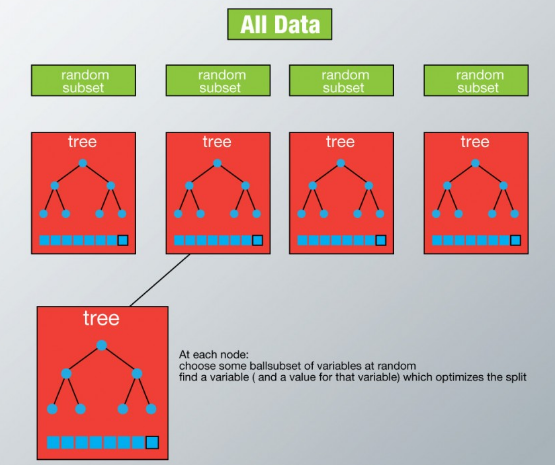

In [54]:
from sklearn.ensemble import RandomForestClassifier

### **Bag-of-Words Features**

First we will train our RandomForest model on the Bag-of-Words features and check its performance on both validation set and public leaderboard.

In [55]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
# validation score 
f1_score(yvalid, prediction)

0.5566188197767145

### **TF-IDF Features**

In [56]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

0.5433212996389891

### **Doc2Vec Features**

In [57]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain) 
prediction = rf.predict(xvalid_d2v) 
f1_score(yvalid, prediction)

0.05405405405405406

---

## **XGBoost**

Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.

Some key benefits of XGBoost are:

1. Regularization - helps in reducing overfitting

2. Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

4. Handling Missing Values - It has an in-built routine to handle missing values.

5. Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process

In [58]:
from xgboost import XGBClassifier

### **Bag-of-Words Features**

In [59]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain) 
prediction = xgb_model.predict(xvalid_bow) 
f1_score(yvalid, prediction)

0.5057692307692307

### **TF-IDF Features**

In [60]:
%%time
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

CPU times: user 21.8 s, sys: 18 ms, total: 21.8 s
Wall time: 21.8 s


0.5147198480531813

### **Word2Vec Features**

In [61]:
%%time
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

CPU times: user 13min 28s, sys: 1.5 s, total: 13min 30s
Wall time: 7min


0.6427931960608774

XGBoost model on word2vec features has outperformed all the previuos models.

### **Doc2Vec Features**

In [62]:
%%time

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain) 
prediction = xgb.predict(xvalid_d2v) 
f1_score(yvalid, prediction)

CPU times: user 14min 38s, sys: 1.81 s, total: 14min 40s
Wall time: 7min 36s


0.34782608695652173

##**FineTuning XGBoost + Word2Vec**

XGBoost with Word2Vec model has given us the best performance so far. Let’s try to tune it further to extract as much from it as we can. XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. This is what we are going to do in the following steps.

In [63]:
import xgboost as xgb

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [64]:
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
dtest = xgb.DMatrix(test_w2v)

In [65]:
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

We will prepare a custom evaluation metric to calculate F1 score.

In [66]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

General Approach for Parameter Tuning

We will follow the steps below to tune the parameters.

1. Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.

2. Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

3. Tune the learning rate.

4. Finally tune gamma to avoid overfitting.

---

### **Tuning max_depth and min_child_weight**

In [67]:
#Tuning max_depth and min_child_weight

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
     for min_child_weight in range(5,8)
 ]


In [68]:
%%time
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
     # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

     # Cross-validation
    cv_results = xgb.cv(        params,
        dtrain,        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )
    # Finding best F1 Score
    
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = cv_results['test-f1_score-mean'].argmax()    
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1)) 

CV with max_depth=6, min_child_weight=5
	F1 Score 0.6861164000000001 for 72 rounds
CV with max_depth=6, min_child_weight=6
	F1 Score 0.6786276 for 84 rounds
CV with max_depth=6, min_child_weight=7
	F1 Score 0.6556462 for 29 rounds
CV with max_depth=7, min_child_weight=5
	F1 Score 0.6732824 for 44 rounds
CV with max_depth=7, min_child_weight=6
	F1 Score 0.6891765999999999 for 64 rounds
CV with max_depth=7, min_child_weight=7
	F1 Score 0.6896564 for 74 rounds
CV with max_depth=8, min_child_weight=5
	F1 Score 0.6705803999999999 for 42 rounds
CV with max_depth=8, min_child_weight=6
	F1 Score 0.6769082 for 49 rounds
CV with max_depth=8, min_child_weight=7
	F1 Score 0.6760889999999999 for 65 rounds
CV with max_depth=9, min_child_weight=5
	F1 Score 0.6875274 for 67 rounds
CV with max_depth=9, min_child_weight=6
	F1 Score 0.6729344 for 33 rounds
CV with max_depth=9, min_child_weight=7
	F1 Score 0.6769398 for 43 rounds
Best params: 7, 7, F1 Score: 0.6896564
CPU times: user 52min 50s, sys: 10.1 

In [69]:
#Updating max_depth and min_child_weight parameters.

params['max_depth'] = 7 
params['min_child_weight'] = 6


---

### **Tuning subsample and colsample**

In [70]:
%%time
#Tuning subsample and colsample

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)] ]
max_f1 = 0. 
best_params = None 
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
     # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )
     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5
	F1 Score 0.6574524 for 43 rounds
CV with subsample=0.5, colsample=0.6
	F1 Score 0.6574524 for 43 rounds
CV with subsample=0.5, colsample=0.7
	F1 Score 0.6574524 for 43 rounds
CV with subsample=0.5, colsample=0.8
	F1 Score 0.6574524 for 43 rounds
CV with subsample=0.5, colsample=0.9
	F1 Score 0.6574524 for 43 rounds
CV with subsample=0.6, colsample=0.5
	F1 Score 0.6857176 for 96 rounds
CV with subsample=0.6, colsample=0.6
	F1 Score 0.6857176 for 96 rounds
CV with subsample=0.6, colsample=0.7
	F1 Score 0.6857176 for 96 rounds
CV with subsample=0.6, colsample=0.8
	F1 Score 0.6857176 for 96 rounds
CV with subsample=0.6, colsample=0.9
	F1 Score 0.6857176 for 96 rounds
CV with subsample=0.7, colsample=0.5
	F1 Score 0.6666794 for 47 rounds
CV with subsample=0.7, colsample=0.6
	F1 Score 0.6666794 for 47 rounds
CV with subsample=0.7, colsample=0.7
	F1 Score 0.6666794 for 47 rounds
CV with subsample=0.7, colsample=0.8
	F1 Score 0.6666794 for 47 rounds
CV wit

In [71]:
#Updating subsample and colsample_bytree

params['subsample'] = .8
params['colsample_bytree'] = .5

---

### **Now let’s tune the learning rate.**

In [72]:
%%time
# Now let’s tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
     # Update ETA
    params['eta'] = eta

     # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3
	F1 Score 0.688222 for 108 rounds
CV with eta=0.2
	F1 Score 0.6831847999999999 for 74 rounds
CV with eta=0.1
	F1 Score 0.6910183999999999 for 133 rounds
CV with eta=0.05
	F1 Score 0.6861084 for 192 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.1, F1 Score: 0.6910183999999999
CPU times: user 20min 17s, sys: 6.64 s, total: 20min 23s
Wall time: 11min 7s


In [73]:
params['eta'] = .1

---

### **Let’s have a look at the final list of tuned parameters.**

In [74]:
params
{'colsample': 0.8,
 'colsample_bytree': 0.5, 'eta': 0.1,
 'max_depth': 7, 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.8}

{'colsample': 0.8,
 'colsample_bytree': 0.5,
 'eta': 0.1,
 'max_depth': 7,
 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.8}

Finally we can now use these tuned parameters in our xgboost model. We have used early stopping of 10 which means if the model’s performance doesn’t improve under 10 rounds, then the model training will be stopped.

In [75]:
%%time
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

[0]	Validation-error:0.066222	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.058609	Validation-f1_score:0.133165
[2]	Validation-error:0.056002	Validation-f1_score:0.133165
[3]	Validation-error:0.05621	Validation-f1_score:0.133165
[4]	Validation-error:0.05621	Validation-f1_score:0.133165
[5]	Validation-error:0.05548	Validation-f1_score:0.368926
[6]	Validation-error:0.054229	Validation-f1_score:0.463262
[7]	Validation-error:0.054333	Validation-f1_score:0.525857
[8]	Validation-error:0.05402	Validation-f1_score:0.556308
[9]	Validation-error:0.05402	Validation-f1_score:0.57389
[10]	Validation-error:0.053499	Validation-f1_score:0.590028
[11]	Validation-error:0.053707	Validation-f1_score:0.58967
[12]	Validation-error:0.052352	Validation-f1_score:0.603997
[13]	Validation-error:0.052769	Validation-f1_score:0.608696
[14]	Validatio

Our tuning worked


### **Let’s prepare one final predicion file.**

In [77]:
test_pred = xgb_model.predict(dtest) 
test['label'] = (test_pred >= 0.3).astype(np.int) 
submission = test[['id','label']] 
submission.to_csv('sub_xgb_w2v_finetuned.csv', index=False)


In [78]:
submission

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,1
17195,49158,0


---

## **Summary**

initially we cleaned our raw text data, then we created about 4 different types of feature-set that we can extract from any text data, and finally we used these feature-sets to build models for sentiment analysis. Below is a summary table showing F1 scores for different models and feature-sets.



Word2Vec features turned out to be most useful. Whereas XGBoost with Word2Vec features was the best model for this problem. This clearly shows the power of word embeddings in dealing with NLP problems.